# Self-Driving Car Engineer Nanodegree


## Project 1 : **Finding Lane Lines on the Road** 
***

## a) Pipeline:

    1) Read/Upload the image to be processed.
    2) Conversion into Gray Scale (cv library).
    3) Canny Edge detection in order to higlight edges.
    4) Define a polynomial region of interest (where to find lane lines).
    5) Hough Transformation in order to identify points building a line.
    6) Line drawing
    7) Overlay of the two images (lines detected + original image).
    8) Output testing.

## 0) Setting and methods definition

In [583]:
#importing some useful packages
import matplotlib.pyplot as plt
import cv2
import os, glob
import numpy as np
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import math

def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def gaussian_blur(image, kernel_size=5): 
    # Define a kernel size and apply Gaussian smoothing
    blur_gray = cv2.GaussianBlur(image,(kernel_size, kernel_size),0)
    return blur_gray
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def region_of_interest(edges_image):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon"""
    
    # Create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges_image)   
    ignore_mask_color = 255   

    # Four sided polygon to mask
    imshape = edges_image.shape
    x_ROI = 450
    y_ROI = 300
    vertices = np.array([[(0,imshape[0]),(x_ROI, y_ROI), (x_ROI, y_ROI), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges_image, mask)
    return masked_edges


def hough_transformation(masked_edges):
    """Applies the Hough transformation"""
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 45  #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    hough_lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)
    return hough_lines

def draw_lines(original_image, image, hough_lines, color=[255, 0, 0], thickness=2):
    
    # Creating a blank to draw lines on
    line_image = np.copy(original_image)*0 
    
    # Iterate over the output "lines" and draw lines on the blank
    for line in hough_lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
        
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((image, image, image)) 

    # Draw the lines on the edge image
    lines_drawn = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
    
    return lines_drawn

def mean(list):
    """
    calculate mean of list
    """
    return float(sum(list)) / max(len(list), 1)

def line_interpolation(lines):
    
    shape = starting_image.shape
    height = shape[0]
    width = shape[1]
    # these will be used to calc left lane
    left_slope = 0
    left_offset = 0
    left_count = 0
    
    # these will be used to calc right lane
    right_slope = 0 
    right_offset = 0
    right_count = 0
    
    # handle empty case
    if lines is None:
        return np.zeros((starting_image.shape[0], starting_image.shape[1], 3), dtype=np.uint8)
    
    # aggeragate slope and offset values
    for line in lines:
        # check if it's empty
        x1,y1,x2,y2 = line[0]

        # calc deltas
        dx = x1-x2
        dy = y1-y2

        # avoid division by zero
        if dx == 0:
            continue

        # calc slope and add to avg
        slope = dy/dx

        if slope<0:
            left_slope += slope
            left_offset += y1- slope*x1
            left_count += 1
        elif slope>0:
            right_slope += slope
            right_offset += y1- slope*x1
            right_count += 1
    
    if left_count == 0 or right_count == 0:
        return np.zeros((starting_image.shape[0], starting_image.shape[1], 3), dtype=np.uint8)
    
    # average out to get the left lane line
    left_slope = left_slope/left_count
    left_offset = left_offset/left_count
    
    
    # average out to get the right lane line
    right_slope = right_slope/right_count
    right_offset = right_offset/right_count

    # calculate bottom points lines
    right_bottom = (int((height-1-right_offset)/right_slope),height-1)
    left_bottom = (int((height-1-left_offset)/left_slope),height-1)

    # calculate the intersection point of left and right lines
    horizon_x =  int((right_offset-left_offset)/(left_slope-right_slope))
    horizon_y = int(right_slope*horizon_x+right_offset)
    horizon = (horizon_x, horizon_y)

    # create a new image black image to draw lines on
    lane_img = np.zeros((starting_image.shape[0], starting_image.shape[1], 3), dtype=np.uint8)

    # draw the lines 
    cv2.line(lane_img,left_bottom,horizon,(255,50,50),11)
    cv2.line(lane_img,right_bottom,horizon,(255,50,50),11)

    return lane_img
    

def overlay_images(starting_image, image_line, α=0.8, β=1., γ=0.):
    
    #Overlay the two images
    output_image = cv2.addWeighted(starting_image, 1.0, image_line, 0.50, 0.0)
    return output_image

def image_pipeline(starting_image):
    
    #Image processing pipeline
    gray_starting_image = grayscale(starting_image)
    blur_gray = gaussian_blur(gray_starting_image, kernel_size)
    edges_image = canny(blur_gray, low_threshold, high_threshold)
    masked_edges = region_of_interest(edges_image)
    hough_lines = hough_transformation(masked_edges)
    lane_image = line_interpolation(hough_lines)
    output_image = overlay_images(starting_image, lane_image)
    return output_image
    

## 1) Read in an Image

Read an image containing white lines.

This image is: Starting image


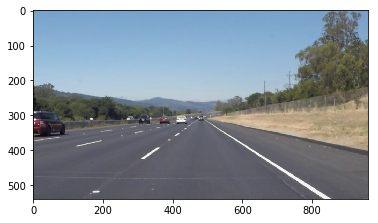

In [584]:
#reading in an image
starting_image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is: Starting image')
plt.imshow(starting_image)

## 2) Conversion into Gray Scale (cv library).

Convert a colored image into a gray one

This image is: Gray image


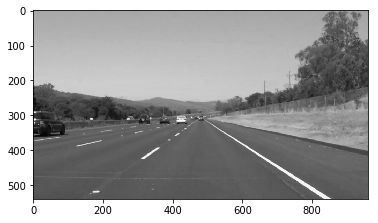

In [585]:

starting_image = cv2.imread('test_images/solidWhiteRight.jpg')
gray_starting_image = grayscale(starting_image)
print('This image is: Gray image')
plt.imshow(gray_starting_image, cmap='gray')

## 3) Canny Edge detection in order to higlight edges.

Find the line boundaries.

This image is: Edge detected


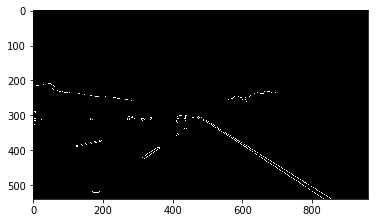

In [586]:
#Gaussian smoothing
kernel_size = 5
blur_gray = gaussian_blur(gray_starting_image, kernel_size)

#Canny edge detection
low_threshold = 100
high_threshold = 300
edges_image = canny(blur_gray, low_threshold, high_threshold)
print('This image is: Edge detected')
plt.imshow(edges_image, cmap='gray')

## 4) Define a polynomial region of interest (where to find lane lines).

Mask the image higlighting the region of interest.

This image is: Edge masked


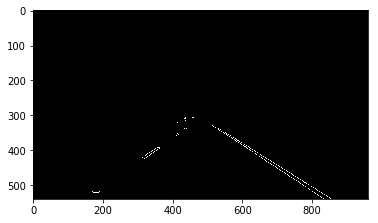

In [587]:
masked_edges = region_of_interest(edges_image)

#Print the image
print('This image is: Edge masked')
plt.imshow(masked_edges, cmap='gray')

## 5) Hough Transformation in order to identify points building a line.

Apply Hough transformation in order to create the line connecting all the line pixel

This image is: Hough Transformed with line


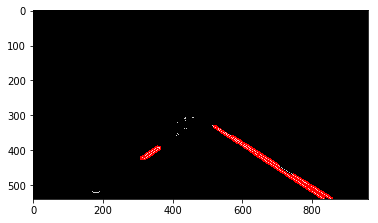

In [588]:
hough_lines = hough_transformation(masked_edges)

hough_transformed = draw_lines(starting_image, masked_edges, hough_lines)

#Print the image
print('This image is: Hough Transformed with line')
plt.imshow(hough_transformed, cmap='gray')

## 6) Line drawing

Average/extrapolate the line segments detected to map out the fullextent of the lane

This image is: Lines drawn


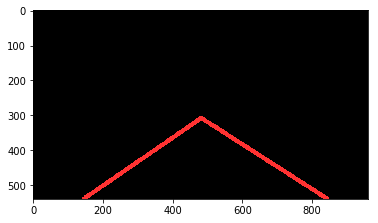

In [589]:
image_line = line_interpolation(hough_lines)

#Print the image
print('This image is: Lines drawn')
plt.imshow(image_line)

## 7) Overlay of the two images (lines detected + original image)

Average/extrapolate the line segments detected to map out the fullextent of the lane

This image is: Lines drawn


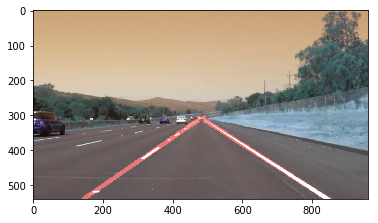

In [590]:
# overlay the empty image with the lines unto the original image with some alpha transparency

overlayed_image = overlay_images(starting_image, image_line)

#Print the image
print('This image is: Lines drawn')
plt.imshow(overlayed_image)

## 8) Output testing

##    a) Pipeline

This image is: Lines drawn


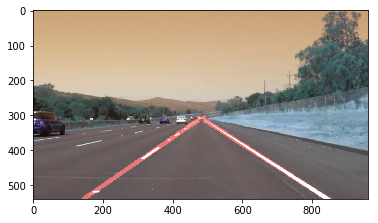

In [591]:
output_image = image_pipeline(starting_image)

#Print the image
print('This image is: Lines drawn')
plt.imshow(output_image)

##    b) White Right

In [593]:
clip1 = VideoFileClip(os.path.join('test_videos', 'solidWhiteRight.mp4'))
processed = clip1.fl_image(image_pipeline)
processed.write_videofile(os.path.join('test_videos_output', 'white_output.mp4'), audio=False)

[MoviePy] >>>> Building video test_videos_output/white_output.mp4
[MoviePy] Writing video test_videos_output/white_output.mp4




  0%|          | 0/222 [00:00<?, ?it/s]

  2%|▏         | 5/222 [00:00<00:05, 42.04it/s]

  5%|▍         | 10/222 [00:00<00:04, 43.60it/s]

  7%|▋         | 15/222 [00:00<00:04, 44.23it/s]

  9%|▉         | 20/222 [00:00<00:04, 44.37it/s]

 11%|█▏        | 25/222 [00:00<00:04, 44.89it/s]

 14%|█▎        | 30/222 [00:00<00:04, 45.17it/s]

 16%|█▌        | 35/222 [00:00<00:04, 46.32it/s]

 18%|█▊        | 40/222 [00:00<00:03, 46.56it/s]

 20%|██        | 45/222 [00:01<00:07, 23.75it/s]

 22%|██▏       | 49/222 [00:01<00:09, 19.11it/s]

 23%|██▎       | 52/222 [00:01<00:09, 17.02it/s]

 25%|██▍       | 55/222 [00:02<00:10, 15.51it/s]

 26%|██▌       | 58/222 [00:02<00:11, 14.86it/s]

 27%|██▋       | 60/222 [00:02<00:11, 14.19it/s]

 28%|██▊       | 62/222 [00:02<00:11, 13.70it/s]

 29%|██▉       | 64/222 [00:02<00:11, 13.71it/s]

 30%|██▉       | 66/222 [00:02<00:11, 13.60it/s]

 31%|███       | 68/222 [00:03<00:11, 13.29it/s]

 32%|███▏      | 70/222 [00:03<00:11, 13.29it/s]

 32%|███

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/white_output.mp4 



In [604]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./test_videos_output/white_ouput.mp4'))

##    c) Yellow Left

In [601]:
yellow_output = 'test_videos_output/yellow_output.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(image_pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/yellow_output.mp4
[MoviePy] Writing video test_videos_output/yellow_output.mp4




  0%|          | 0/682 [00:00<?, ?it/s]

  1%|          | 4/682 [00:00<00:20, 33.78it/s]

  1%|          | 8/682 [00:00<00:19, 35.41it/s]

  2%|▏         | 13/682 [00:00<00:18, 36.63it/s]

  2%|▏         | 17/682 [00:00<00:18, 36.75it/s]

  3%|▎         | 21/682 [00:00<00:17, 37.62it/s]

  4%|▎         | 25/682 [00:00<00:17, 37.81it/s]

  4%|▍         | 29/682 [00:00<00:17, 37.81it/s]

  5%|▍         | 33/682 [00:00<00:17, 38.12it/s]

  5%|▌         | 37/682 [00:00<00:16, 38.37it/s]

  6%|▌         | 41/682 [00:01<00:16, 38.26it/s]

  7%|▋         | 45/682 [00:01<00:29, 21.89it/s]

  7%|▋         | 48/682 [00:01<00:34, 18.31it/s]

  7%|▋         | 51/682 [00:01<00:37, 16.79it/s]

  8%|▊         | 54/682 [00:02<00:38, 16.25it/s]

  8%|▊         | 56/682 [00:02<00:38, 16.07it/s]

  9%|▊         | 58/682 [00:02<00:39, 15.71it/s]

  9%|▉         | 60/682 [00:02<00:40, 15.24it/s]

  9%|▉         | 62/682 [00:02<00:40, 15.27it/s]

  9%|▉         | 64/682 [00:02<00:42, 14.40it/s]

 10%|▉   

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/yellow_output.mp4 

CPU times: user 8.38 s, sys: 835 ms, total: 9.21 s
Wall time: 49.9 s


In [602]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./test_videos_output/yellow.mp4'))

##    d) Challange

In [603]:
challenge_output = 'test_videos_output/challenge_output.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(image_pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

error: /tmp/build/80754af9/opencv_1512491964794/work/modules/core/src/arithm.cpp:659: error: (-209) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function arithm_op


In [600]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./test_videos_output/challenge_output.mp4'))